### Alpha Expansion Algorithm

In the alpha-expansion graph construction, there is one vertex associated with each pixel.
Each of these vertices is connected to the source (representing keeping the original label or
$ \overline{\alpha }$ ) and the sink (representing the label $\alpha$).


The remaining structure of the graph is dynamic: it changes at each iteration depending
on the choice of α and the current labels. There are four possible relationships between
adjacent pixels:

- They can both already be set to alpha.
- One can be set to alpha and the other to another value β.
- Both can be set to the same other value β .
- They can be set to two other values β and γ.


<img src="Alpha_expansion_graph.png" alt="Alpha Expansion" style="width: 600px;"/>

In [1]:
import numpy as np
import cv2
import networkx as nx
import maxflow

import matplotlib.pyplot as plt

from plot_utils import plot_result

EPS = 1e-20

In [2]:
def get_neighbors(img, i, j):
    neighbors = []
    if i < img.shape[0]-1:
        neighbors.append((i+1, j))
    if j < img.shape[1]-1:
        neighbors.append((i, j+1))
    return neighbors

In [4]:
def alpha_expansion(I, label, rho=0.1, pairwise_cost_diff=1):
    ### Create Graph
    g = maxflow.Graph[float]()
    ### Add pixels as nodes
    nodeids = g.add_grid_nodes(I.shape)

    keep_label_cost    = -np.log(rho)  
    change_label_cost  = -np.log((1-rho)/2)
    
    ### Potts Model
    ### Same node = 0
    ### Different label node = 1

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            source_cost     = keep_label_cost
            if I[i,j] == label:
                sink_cost       = -np.log(EPS)
            else:
                sink_cost      = change_label_cost
            
            ### Add connections of the node at (i, j) to source and sink
            g.add_tedge(nodeids[i,j], source_cost, sink_cost)
            
            i_j_neighbors = get_neighbors(I, i, j)

            for neighbor in i_j_neighbors:
                i_neighbor, j_neighbor = neighbor

                # Edges from \alpha to \alpha (\alpha expansion)
                if I[i, j] == label and I[i_neighbor, j_neighbor] == label:
                    g.add_edge(nodeids[i, j],
                               nodeids[i_neighbor, j_neighbor],
                               0,
                               0)

                ## Edges from (\gamma or \beta) to \alpha (\alpha expansion)
                elif I[i, j] != label and I[i_neighbor, j_neighbor] == label:
                    g.add_edge(nodeids[i, j],
                               nodeids[i_neighbor, j_neighbor],
                               pairwise_cost_diff,
                               0)

                ## Edges from \alpha to (\gamma or \beta) (\alpha expansion)
                elif I[i, j] == label and I[i_neighbor, j_neighbor] != label:
                    g.add_edge(nodeids[i, j],
                               nodeids[i_neighbor, j_neighbor], 
                               0,
                               pairwise_cost_diff)

                ## Edges from (\gamma to \gamma) or (\beta to \beta) (\alpha expansion)
                elif I[i, j] != label and I[i_neighbor, j_neighbor] != label and I[i, j] == I[i_neighbor, j_neighbor]:
                    g.add_edge(nodeids[i, j],
                               nodeids[i_neighbor, j_neighbor],
                               pairwise_cost_diff,
                               pairwise_cost_diff)

                ## Edges from (\gamma to \beta) to (\beta to \gamma) (\alpha expansion)
                elif I[i, j] != label and I[i_neighbor, j_neighbor] != label and I[i, j] != I[i_neighbor, j_neighbor]:

                    # adding an extra node to the graph
                    new_node = g.add_nodes(1)

                    # adding the edges of new node to the graph
                    g.add_edge(nodeids[i, j],
                               new_node,
                               pairwise_cost_diff,
                               -np.log(EPS))
                    g.add_edge(nodeids[i_neighbor, j_neighbor],
                               new_node,
                               pairwise_cost_diff,
                               -np.log(EPS))

                    # connecting the new node to the sink node
                    g.add_tedge(new_node, 0, pairwise_cost_diff)
    
    
    g.maxflow()
    sgm = g.get_grid_segments(nodeids)
    return sgm


In [5]:
def denoise_grayscale_image(img, rho, pairwise_cost_diff):
    result_dict = {}
    
    labels = np.unique(img)
    segment_dict = {}
    denoised_img = img.copy()
    for label in labels:
        segment = alpha_expansion(denoised_img, 
                                  label,
                                  rho=rho,
                                  pairwise_cost_diff=pairwise_cost_diff)
        denoised_img[segment==True] = label
        segment_dict[label] = segment
    
    result_dict['segments'] = segment_dict
    
    denoised_img = denoised_img.astype('uint8')
    result_dict['denoised_img'] = denoised_img
    return result_dict

## Alpha expansion algorithm for grayscale image

There are only three labels $[l_1, l_2, l_3]$ where $l_1=0$, $l_2=1$ and $l_3=2$ corresponding to gray values of $(0,128,255)$ respectively.

Unary costs are defined as:

$$
\begin{align*}
P(x_n = l_{i} | w_{n} = l_{i} ) &&  =  && \rho                 &&  \\
P(x_n = l_{j} | w_{n} = l_{i} ) &&  =  && \frac{(1 - \rho)}{2} && \, \forall \, i \neq j \\
\end{align*}
$$

where $\rho = 0.1$

Pairwise cost using Potts model:

- Same label           = 0
- Different label node = 1

In [6]:
img = cv2.imread('./images/noisy_grayscale_img.png', cv2.IMREAD_GRAYSCALE)

pairwise_diff = 1

/tmp/ipykernel_1931904/3749777917.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g.add_edge(nodeids[i, j],
/tmp/ipykernel_1931904/3749777917.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g.add_edge(nodeids[i_neighbor, j_neighbor],
/tmp/ipykernel_1931904/3749777917.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  g.add_tedge(new_node, 0, pairwise_cost_diff)


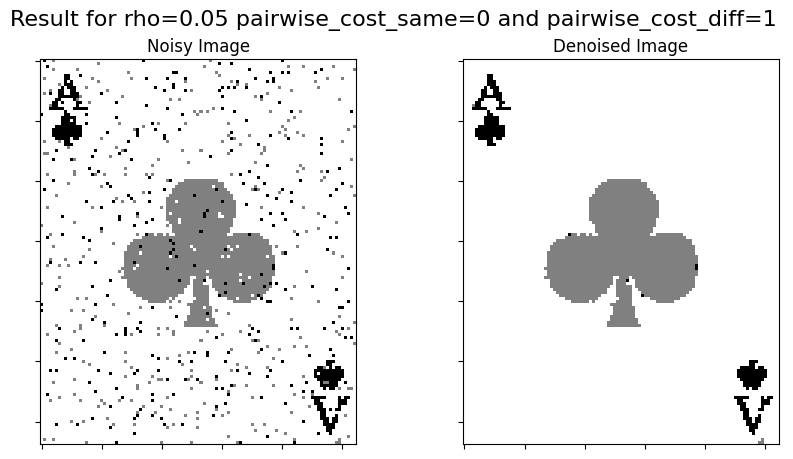

In [7]:
rho = 0.05
result = denoise_grayscale_image(img, rho=rho, pairwise_cost_diff=pairwise_diff)
plot_result(img, 
            result['denoised_img'],
            rho=rho, 
            pairwise_same=0,
            pairwise_diff=pairwise_diff,
            figsize=(10, 5))

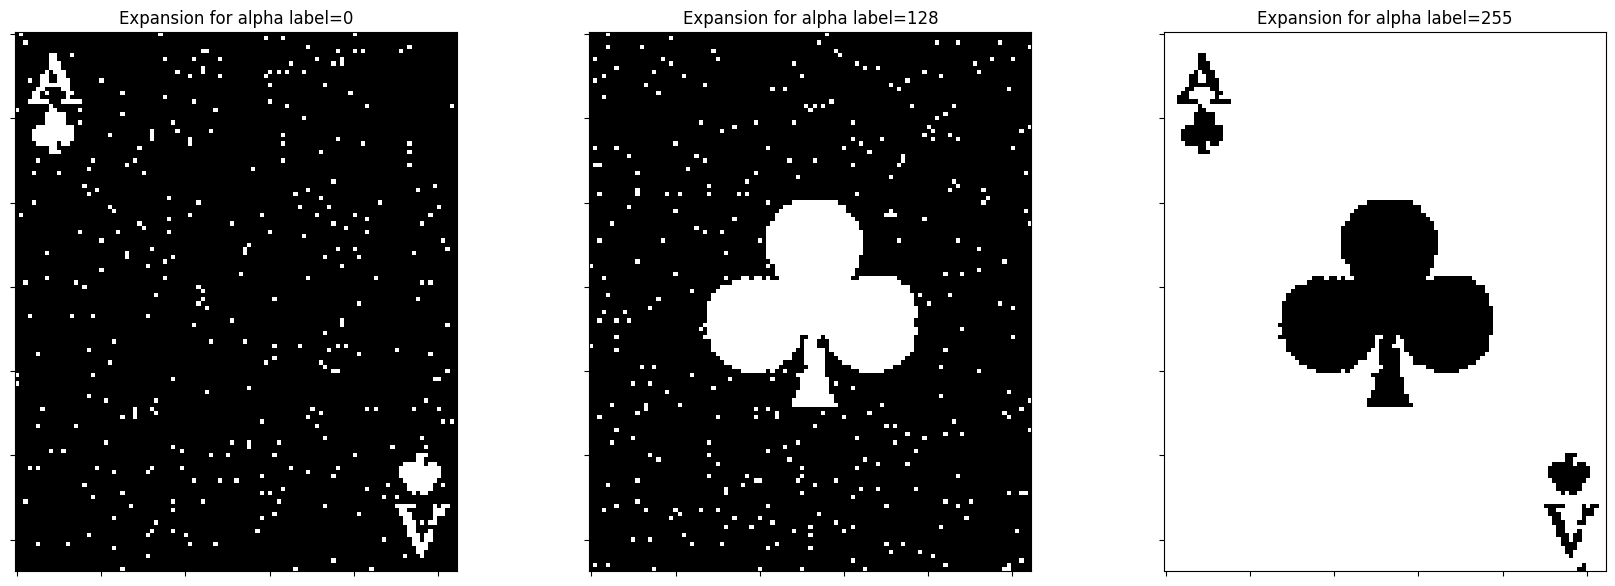

In [8]:
segment_dict = result['segments']
fig, axes = plt.subplots(ncols=3, figsize=(21, 7))

for idx, (lbl, sgm) in enumerate(segment_dict.items()):
    axes[idx].imshow(sgm, cmap='gray')
    axes[idx].set_title(f"Expansion for alpha label={lbl}")
    axes[idx].tick_params(labelbottom=False, labelleft=False)